In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
import awkward as ak
import uproot 
import mplhep as hep
import hist
import os
import time
from numba import njit
from matplotlib.colors import LogNorm
import tqdm
import pickle 
from numba import jit



from UtilityAndConst import *
from Functions import *

dir = "/Users/francescolarovere/Documents/Tesi-Triennale/Dati"
os.chdir(dir)

hep.style.use("CMS")
np.set_printoptions(threshold=np.inf)

In [2]:
files = [
    "./ntupleStubsBmtfGmt_LS122.root",
    "./ntupleStubsBmtfGmt_LS133.root",
    "./ntupleStubsBmtfGmt_LS159.root",
    "./ntupleStubsBmtfGmt_LS170.root",
    "./ntupleStubsBmtfGmt_LS214.root",
    "./ntupleStubsBmtfGmt_LS237.root",
    "./ntupleStubsBmtfGmt_LS251.root",
    "./ntupleStubsBmtfGmt_LS258.root",
    "./ntupleStubsBmtfGmt_LS263.root",
    "./ntupleStubsBmtfGmt_LS264.root",
    "./ntupleStubsBmtfGmt_LS277.root",
    "./ntupleStubsBmtfGmt_LS290.root",
    "./ntupleStubsBmtfGmt_LS299.root",
    "./ntupleStubsBmtfGmt_LS306.root",
]

stub_bmtf_gmt_features = [
    'bmtfPhi', 'bmtfEta',  
    'bmtfHwQual', 
    'gmtPhi', 'gmtEta', 
    'gmtQual']

stub_bmtf_gmt_list = []
for file in files:
    with uproot.open(file) as f:
        evs = f["bmtfNtuplizer/Events"]
        temp_awk = evs.arrays(stub_bmtf_gmt_features, library="ak")
        stub_bmtf_gmt_list.append(temp_awk)
        
bmtf_gmt = ak.concatenate(stub_bmtf_gmt_list, axis=0)



In [3]:
GmtEta = bmtf_gmt.gmtEta
BmtfEta = bmtf_gmt.bmtfEta
GmtPhi = bmtf_gmt.gmtPhi
BmtfPhi = bmtf_gmt.bmtfPhi
GmtPt = bmtf_gmt.gmtPt
BmtfPt = bmtf_gmt.bmtfPt
nBmtfMuons = bmtf_gmt.nBmtfMuons
nGmtMuons = bmtf_gmt.nGmtMuons
BmtfQual = bmtf_gmt.bmtfHwQual
GmtQual = bmtf_gmt.gmtQual

AttributeError: no field named 'gmtPt'

In [ ]:
def Delta(BMTF, GMT):
  return BMTF - GMT

def DeltaR(BmtfPhi, GmtPhi, BmtfEta, GmtEta):
  return np.sqrt((BmtfPhi - GmtPhi)**2 + (BmtfEta - GmtEta)**2)

def CheckDuplicates(j, IndexMin, DeltaRDist, DeltaRTemp, indexTemp):
  
  IndexMin.pop(j)
  #Creo una maschera per il vecchio minimo
  Mask = np.ones(DeltaRTemp.shape, dtype=bool)
  Mask[indexTemp] = False
  Sec_minDeltaR = np.min(DeltaRTemp[Mask])
  #Trovo il nuovo minimo, applicando la maschera a DeltaRTemp
  Sec_indexTemp = np.argwhere((DeltaRTemp == Sec_minDeltaR) & Mask)[0][0]

  DeltaRDist.append(Sec_minDeltaR)
  IndexMin.append(Sec_indexTemp)

  return DeltaRDist, IndexMin


In [ ]:
'''Funzione per calcolare DeltaR e Pt'''
def DeltaRDist(nBmtfMuons, nGmtMuons, Bmtf_Phi, Gmt_Phi, Bmtf_Eta, Gmt_Eta, Bmtf_Pt, Gmt_Pt, Bmtf_Qual, Gmt_Qual, Number):
  MuonsProperties = []

  for i in tqdm.tqdm(range(Number)):

    #Fare in questo modo ottimizza enormemente il processo!
    nBmtfM, nGmtM = nBmtfMuons[i], nGmtMuons[i]
    ArrBmtfPhi, ArrBmtfEta = ak.to_numpy(Bmtf_Phi[i]), ak.to_numpy(Bmtf_Eta[i])
    ArrGmtPhi, ArrGmtEta = ak.to_numpy(Gmt_Phi[i]), ak.to_numpy(Gmt_Eta[i])
    ArrBmtfPt, ArrGmtPt = ak.to_numpy(Bmtf_Pt[i]), ak.to_numpy(Gmt_Pt[i])
    ArrBmtfPhi, ArrBmtfEta = ak.to_numpy(Bmtf_Phi[i]), ak.to_numpy(Bmtf_Eta[i])
    ArrGmtPhi, ArrGmtEta = ak.to_numpy(Gmt_Phi[i]), ak.to_numpy(Gmt_Eta[i])
    ArrBmtfQual, ArrGmtQual = ak.to_numpy(Bmtf_Qual[i]), ak.to_numpy(Gmt_Qual[i])

    DeltaRDistBMTF, DeltaRDistGMT = [], []
    IndexMinBMTF, IndexMinGMT = [], []
    PtBMTF, PtGMT = [], []
    nBmtfM, nGmtM = nBmtfMuons[i], nGmtMuons[i]


    PhiGMT, PhiBMTF = [], []
    EtaGMT, EtaBMTF = [], []
    QualGMT, QualBMTF = [], []

    ArrDeltaPhiBMTF, ArrDeltaEtaBMTF = [], []
    ArrDeltaPhiGMT, ArrDeltaEtaGMT = [], []


    #Controllo globale dei match 
    if nGmtM == 0 and nBmtfM == 0:
      unmatched_Bmtf = []
      unmatched_Gmt = []
    
    elif nBmtfM == 0:
      unmatched_Bmtf = []
      unmatched_Gmt = [i for i in range(nGmtM)]

    elif nGmtM == 0:
      unmatched_Bmtf = [i for i in range(nBmtfM)]
      unmatched_Gmt = []


    else:
      #Primo metodo 
      for j in range(nBmtfM):

        #Calcolo il DeltaR
        DeltaRTemp = DeltaR(ArrBmtfPhi[j], ArrGmtPhi[:], ArrBmtfEta[j], ArrGmtEta[:])

        #Attento a come sono definiti IndexMin nei vari casi! Nel primo caso è confronto con tutti i muoni del GMT!
        minDeltaR = np.min(DeltaRTemp)
        indexTempGMT = np.argmin(DeltaRTemp)
        IndexMinGMT.append(indexTempGMT)

        if minDeltaR < 0.4:
          
          #Controllo che non vengano assegnati gli stessi indici dei minimi a muoni diversi
          if IndexMinGMT[j] in IndexMinGMT[:j] and nBmtfM == nGmtM:

            DeltaRDistBMTF, IndexMinGMT = CheckDuplicates(j, IndexMinGMT, DeltaRDistBMTF, DeltaRTemp, indexTempGMT)
                        
          else:
            DeltaRDistBMTF.append(minDeltaR)

          I = IndexMinGMT[j]

          #Salvataggio nel rispettivo BX degli eventi con match
          DeltaPhi_BMTF = Delta(ArrBmtfPhi[j], ArrGmtPhi[I])
          DeltaEta_BMTF = Delta(ArrBmtfEta[j], ArrGmtEta[I])
          ArrDeltaPhiBMTF.append(DeltaPhi_BMTF)
          ArrDeltaEtaBMTF.append(DeltaEta_BMTF)

          
        else:
          #Se DeltaR > 0.4 (primo metodo) non c'è match con i muoni del GMT
          unmatched_Gmt = [i for i in range(nGmtM)]
    
      
        matched_Bmtf_Index = [i for i in IndexMinGMT if IndexMinGMT]
        unmatched_Bmtf = [i for i in range(nBmtfM) if i not in matched_Bmtf_Index]
        

      #Secondo metodo 
      for k in range(nGmtM):
        DeltaRTemp = DeltaR(ArrBmtfPhi[:], ArrGmtPhi[k], ArrBmtfEta[:], ArrGmtEta[k])

        minDeltaR = np.min(DeltaRTemp)
        indexTempBMTF = np.argmin(DeltaRTemp)
        IndexMinBMTF.append(indexTempBMTF)

        if minDeltaR < 0.4:
          
          #Controllo duplicati 
          if IndexMinBMTF[k] in IndexMinBMTF[:k] and nBmtfM == nGmtM:
          
            DeltaRDistGMT, IndexMinBMTF = CheckDuplicates(k, IndexMinBMTF, DeltaRDistGMT, DeltaRTemp, indexTempBMTF)
          
          else:
            DeltaRDistGMT.append(minDeltaR)

          I = IndexMinBMTF[k]

          #Salvataggio nel rispettivo BX degli eventi con match
          DeltaPhi_GMT = Delta(ArrBmtfPhi[I], ArrGmtPhi[k])
          DeltaEta_GMT = Delta(ArrBmtfEta[I], ArrGmtEta[k])
          ArrDeltaPhiGMT.append(DeltaPhi_GMT)
          ArrDeltaEtaGMT.append(DeltaEta_GMT)
          PtBMTF.append(ArrBmtfPt[I])
          PtGMT.append(ArrGmtPt[k])
          PhiBMTF.append(ArrBmtfPhi[I])
          PhiGMT.append(ArrGmtPhi[k])
          EtaBMTF.append(ArrBmtfEta[I])
          EtaGMT.append(ArrGmtEta[k])
          QualBMTF.append(ArrBmtfQual[I])
          QualGMT.append(ArrGmtQual[k])

          
        else:
          unmatched_Bmtf = [i for i in range(nBmtfM)]

    #Salvataggio nel dizionario
    Events = {
      'unmatched_Gmt_Events' : unmatched_Gmt,
      'unmatched_Bmtf_Events': unmatched_Bmtf, 
      'nGmtMuons': nGmtM,
      'nBmtfMuons': nBmtfM,
      #DeltaPhi, DeltaEta dei due metodi
      'DeltaPhiBMTF': ArrDeltaPhiBMTF,
      'DeltaEtaBMTF': ArrDeltaEtaBMTF,
      'DeltaPhiGMT': ArrDeltaPhiGMT,
      'DeltaEtaGMT': ArrDeltaEtaGMT,

       #tutti i Pt
      'AllPtBMTF': ArrBmtfPt,
      'AllPtGMT': ArrGmtPt,
      'AllQualBMTF': ArrBmtfQual, 
      'AllQualGMT': ArrGmtQual, 
      'AllPhiBmtf': ArrBmtfPhi,
      'AllPhiGmt': ArrGmtPhi,
      'AllEtaBmtf': ArrBmtfEta,
      'AllEtaGmt': ArrGmtEta,

      #Solo i Pt che hanno fatto il match
      'PtBMTF': PtBMTF,
      'PtGMT': PtGMT, 
      'QualBmtf': QualBMTF, 
      'QualGmt': QualGMT, 
      'PhiBmtf': PhiBMTF,
      'PhiGmt': PhiGMT,
      'EtaBmtf': EtaBMTF,
      'EtaGmt': EtaGMT 

    }

    MuonsProperties.append(Events)


  return ak.Array(MuonsProperties)

In [ ]:
#MuonsPropertiesAll = DeltaRDist(nBmtfMuons, nGmtMuons, BmtfPhi, GmtPhi, BmtfEta, GmtEta, BmtfPt, GmtPt, BmtfQual, GmtQual, Number = len(nBmtfMuons))

In [ ]:
# #Save Dictionary
# with open('ElevenThirteenLS.pkl', 'wb') as f:
#     pickle.dump(MuonsPropertiesAll, f)

In [2]:
#Open Dictionary 

# with open('MuonsProperties.pkl', 'rb') as f:
#     MuonsProperties = pickle.load(f)

# with open('MuonMatchEff.pkl', 'rb') as f:
#     MuonMatchEff = pickle.load(f)

# with open('MuonsPropertiesAll.pkl', 'rb') as f:
#     MuonsPropertiesAll = pickle.load(f)


with open('FirstTwoLS.pkl', 'rb') as f:
    FirstTwoLS = pickle.load(f)

with open('TwoFourLS.pkl', 'rb') as f:
    TwoFourLS = pickle.load(f)

with open('FourSixLS.pkl', 'rb') as f:
    FourSixLS = pickle.load(f)

with open('SixNineLS.pkl', 'rb') as f:
    SixNineLS = pickle.load(f)

with open('NineToElevenLS.pkl', 'rb') as f:
    NineToElevenLS = pickle.load(f)

with open('ElevenThirteenLS.pkl', 'rb') as f:
    ElevenThirteenLS = pickle.load(f)



MuonsPropertiesAll = np.concatenate([FirstTwoLS, TwoFourLS, FourSixLS, SixNineLS, NineToElevenLS, ElevenThirteenLS])

In [5]:
MuonsPropertiesAll

<Array [{unmatched_Gmt_Events: [], ...}, ...] type='40525476 * {unmatched_G...'>

In [6]:
print("# of unmatched BMTF = ", ak.sum(ak.num(MuonsPropertiesAll.unmatched_Bmtf_Events)))
print("# of unmatched GMT = ", ak.sum(ak.num(MuonsPropertiesAll.unmatched_Gmt_Events)))

Tot_Unmatched_GMT = ak.sum(ak.num(MuonsPropertiesAll.unmatched_Gmt_Events))
Tot_Unmatched_BMTF = ak.sum(ak.num(MuonsPropertiesAll.unmatched_Bmtf_Events))

Tot_Matched_GMT = ak.sum(MuonsPropertiesAll.nGmtMuons)
Tot_Matched_BMTF = ak.sum(MuonsPropertiesAll.nBmtfMuons)

fractionBMTF = Tot_Unmatched_BMTF / Tot_Matched_BMTF * 100
fractionGMT = Tot_Unmatched_GMT / Tot_Matched_GMT * 100

print(f"unmatchedGMT: {fractionGMT:.2f}, unmatchedBMTF: {fractionBMTF:.2f}")

# of unmatched BMTF =  441621
# of unmatched GMT =  16987
unmatchedGMT: 0.23, unmatchedBMTF: 5.60


/var/folders/73/kb390p311j3ctnbn_v15y42w0000gn/T/ipykernel_67433/1363071608.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 200)
/var/folders/73/kb390p311j3ctnbn_v15y42w0000gn/T/ipykernel_67433/1363071608.py:48: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


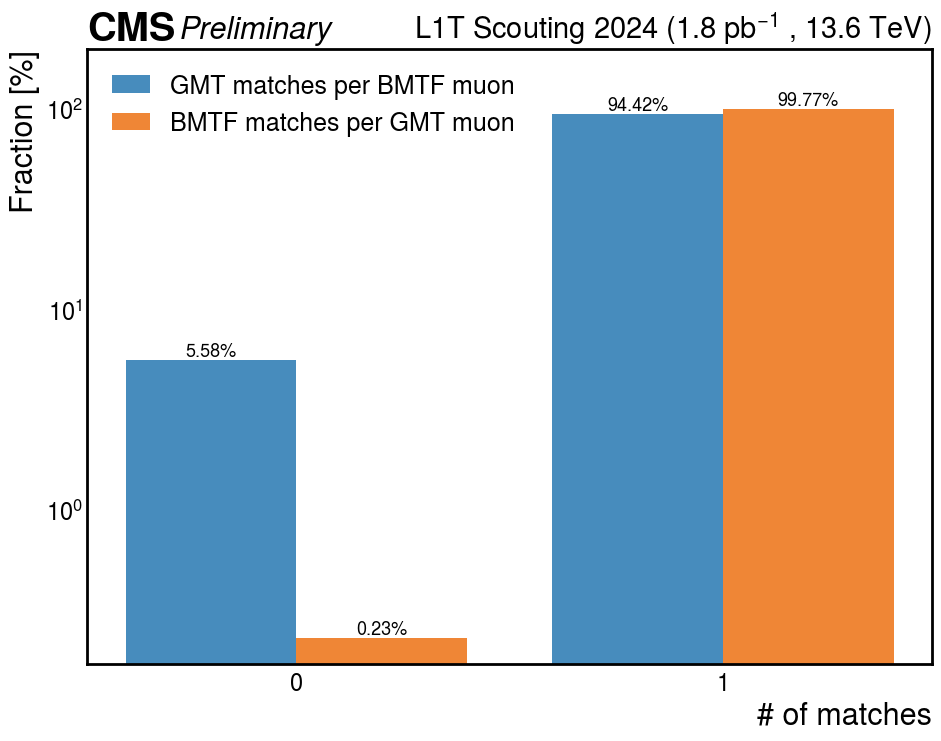

In [7]:

categories = ['0', '1']
gmt_matches = [5.58, 100-5.58]   # Percentuali di corrispondenza per GMT matches per BMTF muon
bmtf_matches = [0.23, 100 - 0.23]

# Imposta larghezza barre
bar_width = 0.4
index = np.arange(len(categories))

# Crea il grafico a barre
fig, ax = plt.subplots(figsize = FIGSIZE, constrained_layout=True)

set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE-2)

draw_cms_label(ax, fontsize= FONTSIZE)

bar1 = ax.bar(index, gmt_matches, bar_width, label='GMT matches per BMTF muon', color='#478CBD')
bar2 = ax.bar(index + bar_width, bmtf_matches, bar_width, label='BMTF matches per GMT muon', color='#EF8636')

# Imposta scala logaritmica per l'asse y
ax.set_yscale('log')

# Aggiungi etichette, titolo e personalizzazioni
ax.set_xlabel('# of matches', fontsize = FONTSIZE)
ax.set_ylabel('Fraction [%]', fontsize = FONTSIZE)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(categories)
ax.legend(fontsize = FONTSIZE-4)

# Aggiungi annotazioni sulle barre
for rect, label in zip(bar1, gmt_matches):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, f'{label:.2f}%', ha='center', va='bottom', fontsize=13)

for rect, label in zip(bar2, bmtf_matches):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, f'{label:.2f}%', ha='center', va='bottom', fontsize=13)


ax.set_ylim(0, 200)

ax.tick_params(axis='both', which='both', labelsize = FONTSIZE - 5, length = 0)

# Mostra il grafico

#plt.savefig("../Immagini/Percentile.pdf")

plt.tight_layout()
plt.show()

In [4]:
#----------------------------Pt---------------------------------
PtBMTF = ak.flatten(MuonsPropertiesAll.PtBMTF)
PtGMT = ak.flatten(MuonsPropertiesAll.PtGMT)

AllPtBMTF = ak.flatten(MuonsPropertiesAll.AllPtBMTF)
AllPtGMT = ak.flatten(MuonsPropertiesAll.AllPtGMT)

#----------------------------Phi---------------------------------
PhiBMTF = ak.flatten(MuonsPropertiesAll.PhiBmtf)
PhiGMT = ak.flatten(MuonsPropertiesAll.PhiGmt)

AllPhiBMTF = ak.flatten(MuonsPropertiesAll.AllPhiBmtf)
AllPhiGMT = ak.flatten(MuonsPropertiesAll.AllPhiGmt)

#----------------------------Eta---------------------------------
EtaBMTF = ak.flatten(MuonsPropertiesAll.EtaBmtf)
EtaGMT = ak.flatten(MuonsPropertiesAll.EtaGmt)

AllEtaBMTF = ak.flatten(MuonsPropertiesAll.AllEtaBmtf)
AllEtaGMT = ak.flatten(MuonsPropertiesAll.AllEtaGmt)

#----------------------------Qual---------------------------------
QualBMTF = ak.flatten(MuonsPropertiesAll.QualBmtf)
QualGMT = ak.flatten(MuonsPropertiesAll.QualGmt)

AllQualBMTF = ak.flatten(MuonsPropertiesAll.AllQualBMTF)
AllQualGMT = ak.flatten(MuonsPropertiesAll.AllQualGMT)

In [5]:
bins = np.array([0, 5, 10, 15, 20, 30, 40, 50, 100, 300])

#-------------------------Histograms---------------------------------
PtBMTF_Hist = hist.Hist(hist.axis.Variable(bins, name="pTBMTF", label="BMTF Muon pT [GeV]"))
AllPtBMTF_Hist = hist.Hist(hist.axis.Variable(bins, name="AllpTBMTF", label="BMTF Muon pT [GeV]"))
PtGMT_Hist = hist.Hist(hist.axis.Variable(bins, name="pTGMT", label="GMT Muon pT [GeV]"))
AllPtGMT_Hist = hist.Hist(hist.axis.Variable(bins, name="AllpTGMT", label="GMT Muon pT [GeV]"))


PtBMTF_Hist.fill(pTBMTF=PtBMTF)
AllPtBMTF_Hist.fill(AllpTBMTF=AllPtBMTF)

BMTFMatchingEfficiencyPt = PtBMTF_Hist.values()/AllPtBMTF_Hist.values()


PtGMT_Hist.fill(pTGMT=PtGMT)
AllPtGMT_Hist.fill(AllpTGMT=AllPtGMT)

GMTMatchingEfficiencyPt = PtGMT_Hist.values()/AllPtGMT_Hist.values()

print(PtBMTF_Hist)

                    ┌────────────────────────────────────────────────────────┐
[-inf,   0) 0       │                                                        │
[   0,   5) 3991814 │███████████████████████████████████████████████████████ │
[   5,  10) 2879060 │███████████████████████████████████████▋                │
[  10,  15) 418639  │█████▊                                                  │
[  15,  20) 87649   │█▎                                                      │
[  20,  30) 41105   │▋                                                       │
[  30,  40) 11621   │▏                                                       │
[  40,  50) 5207    │▏                                                       │
[  50, 100) 7280    │▏                                                       │
[ 100, 300) 5086    │▏                                                       │
[ 300, inf) 0       │                                                        │
                    └───────────────────────────────

In [6]:
binsPhi = np.array(np.arange(-np.pi, np.pi + 0.1, 0.52))

#-------------------------Histograms---------------------------------
PhiBMTF_Hist = hist.Hist(hist.axis.Variable(binsPhi, name="PhiBMTF", label="BMTF Muon Phi"))
AllPhiBMTF_Hist = hist.Hist(hist.axis.Variable(binsPhi, name="AllPhiBMTF", label="BMTF Muon Phi"))
PhiGMT_Hist = hist.Hist(hist.axis.Variable(binsPhi, name="PhiGMT", label="GMT Muon Phi"))
AllPhiGMT_Hist = hist.Hist(hist.axis.Variable(binsPhi, name="AllPhiGMT", label="GMT Muon Phi"))


PhiBMTF_Hist.fill(PhiBMTF=PhiBMTF)
AllPhiBMTF_Hist.fill(AllPhiBMTF=AllPhiBMTF)

BMTFMatchingEfficiencyPhi = PhiBMTF_Hist.values()/AllPhiBMTF_Hist.values()


PhiGMT_Hist.fill(PhiGMT=PhiGMT)
AllPhiGMT_Hist.fill(AllPhiGMT=AllPhiGMT)

GMTMatchingEfficiencyPhi = PhiGMT_Hist.values()/AllPhiGMT_Hist.values()

print(BMTFMatchingEfficiencyPhi)

print(PhiBMTF_Hist)


[0.94300709 0.95545884 0.96097414 0.96354448 0.94728589 0.93789829
 0.93449316 0.93259128 0.92615276 0.93546511 0.94503101 0.9441587 ]
                            ┌────────────────────────────────────────────────┐
[    -inf,   -3.142) 0      │                                                │
[  -3.142,   -2.622) 590247 │███████████████████████████████████████████▍    │
[  -2.622,   -2.102) 640381 │███████████████████████████████████████████████ │
[  -2.102,   -1.582) 638058 │██████████████████████████████████████████████▉ │
[  -1.582,   -1.062) 614725 │█████████████████████████████████████████████▏  │
[  -1.062,  -0.5416) 638537 │██████████████████████████████████████████████▉ │
[ -0.5416, -0.02159) 635941 │██████████████████████████████████████████████▋ │
[-0.02159,   0.4984) 620781 │█████████████████████████████████████████████▌  │
[  0.4984,    1.018) 587747 │███████████████████████████████████████████▏    │
[   1.018,    1.538) 561933 │█████████████████████████████████████████▎    

In [7]:
binsEta = np.array(np.arange(-1, 1.1, 0.2))

#-------------------------Histograms---------------------------------
EtaBMTF_Hist = hist.Hist(hist.axis.Variable(binsEta, name="EtaBMTF", label="BMTF Muon Eta"))
AllEtaBMTF_Hist = hist.Hist(hist.axis.Variable(binsEta, name="AllEtaBMTF", label="BMTF Muon Eta"))
EtaGMT_Hist = hist.Hist(hist.axis.Variable(binsEta, name="EtaGMT", label="GMT Muon Eta"))
AllEtaGMT_Hist = hist.Hist(hist.axis.Variable(binsEta, name="AllEtaGMT", label="GMT Muon Eta"))

EtaBMTF_Hist.fill(EtaBMTF=EtaBMTF)
AllEtaBMTF_Hist.fill(AllEtaBMTF=AllEtaBMTF)

BMTFMatchingEfficiencyEta = EtaBMTF_Hist.values()/AllEtaBMTF_Hist.values()


EtaGMT_Hist.fill(EtaGMT=EtaGMT)
AllEtaGMT_Hist.fill(AllEtaGMT=AllEtaGMT)

GMTMatchingEfficiencyEta = EtaGMT_Hist.values()/AllEtaGMT_Hist.values()

print(EtaGMT_Hist)

                     ┌───────────────────────────────────────────────────────┐
[-inf,   -1) 43      │                                                       │
[  -1, -0.8) 237524  │███████████▏                                           │
[-0.8, -0.6) 800105  │█████████████████████████████████████▎                 │
[-0.6, -0.4) 1103007 │███████████████████████████████████████████████████▍   │
[-0.4, -0.2) 645566  │██████████████████████████████▏                        │
[-0.2,    0) 656016  │██████████████████████████████▋                        │
[   0,  0.2) 1124175 │████████████████████████████████████████████████████▍  │
[ 0.2,  0.4) 663904  │███████████████████████████████                        │
[ 0.4,  0.6) 1158569 │██████████████████████████████████████████████████████ │
[ 0.6,  0.8) 815337  │██████████████████████████████████████                 │
[ 0.8,    1) 243149  │███████████▍                                           │
[   1,  inf) 66      │                              

In [8]:
binsQual = np.array(np.arange(12, 17, 1))
#-------------------------Histograms---------------------------------
QualBMTF_Hist = hist.Hist(hist.axis.Variable(binsQual, name="QualBMTF", label="BMTF Muon Qual"))
AllQualBMTF_Hist = hist.Hist(hist.axis.Variable(binsQual, name="AllQualBMTF", label="BMTF Muon Qual"))
QualGMT_Hist = hist.Hist(hist.axis.Variable(binsQual, name="QualGMT", label="GMT Muon Qual"))
AllQualGMT_Hist = hist.Hist(hist.axis.Variable(binsQual, name="AllQualGMT", label="GMT Muon Qual"))

QualBMTF_Hist.fill(QualBMTF=QualBMTF)
AllQualBMTF_Hist.fill(AllQualBMTF=AllQualBMTF)

BMTFMatchingEfficiencyQual = QualBMTF_Hist.values()/AllQualBMTF_Hist.values()


QualGMT_Hist.fill(QualGMT=QualGMT)
AllQualGMT_Hist.fill(AllQualGMT=AllQualGMT)

GMTMatchingEfficiencyQual = QualGMT_Hist.values()/AllQualGMT_Hist.values()

print(QualBMTF_Hist)

                    ┌────────────────────────────────────────────────────────┐
[-inf,  12) 0       │                                                        │
[  12,  13) 3576127 │███████████████████████████████████████████████████████ │
[  13,  14) 2745454 │██████████████████████████████████████████▎             │
[  14,  15) 821854  │████████████▋                                           │
[  15,  16) 304026  │████▋                                                   │
[  16, inf) 0       │                                                        │
                    └────────────────────────────────────────────────────────┘


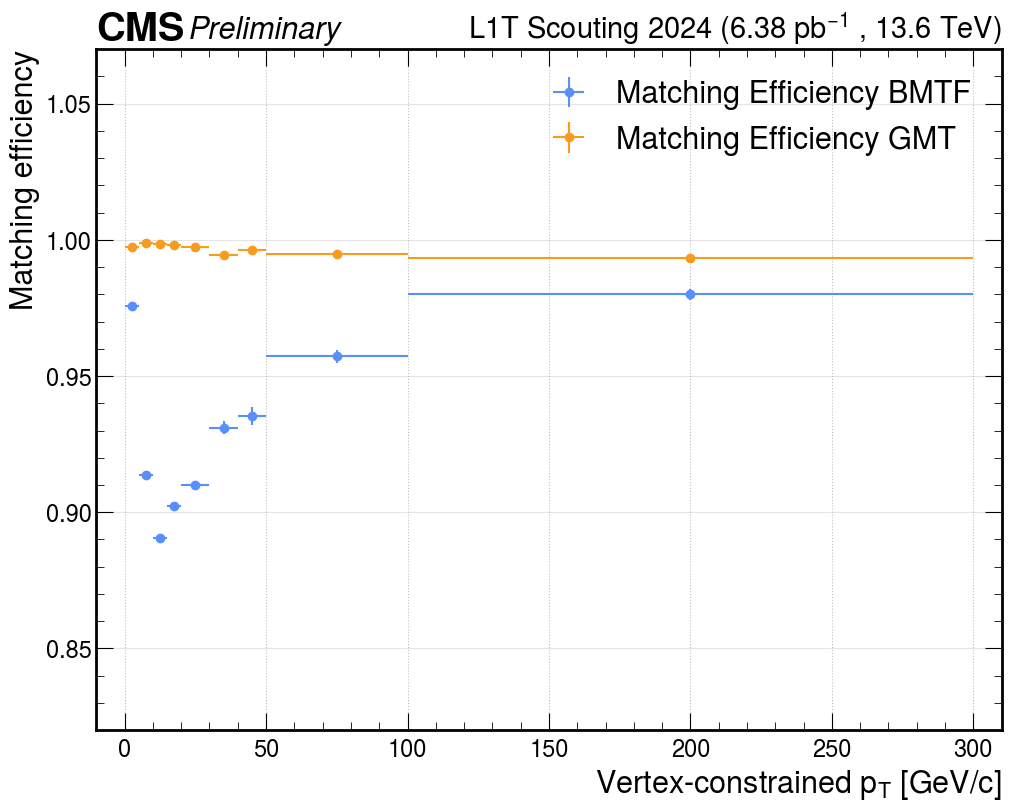

In [9]:
from hist import intervals
BMTFerror = hist.intervals.ratio_uncertainty(PtBMTF_Hist.values(), AllPtBMTF_Hist.values(), uncertainty_type = 'efficiency')
GMTerror = hist.intervals.ratio_uncertainty(PtGMT_Hist.values(), AllPtGMT_Hist.values(), uncertainty_type = 'efficiency')

centers = 0.5 * (bins[1:] + bins[:-1])
width = 0.5 * (bins[1:] - bins[:-1])

fig, ax = plt.subplots(figsize=FIGSIZE, constrained_layout=True)
set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE-2)
draw_grid(ax, axis="y")
MOREdraw_cms_label(ax, fontsize= FONTSIZE)

ax.errorbar(centers, BMTFMatchingEfficiencyPt, xerr = width, yerr = BMTFerror, fmt = 'o', label="Matching Efficiency BMTF")
ax.errorbar(centers, GMTMatchingEfficiencyPt, xerr = width, yerr = GMTerror, fmt = 'o', label="Matching Efficiency GMT")

ax.set_ylim(0.82, 1.07)
ax.set_xlim(-10, 310)


ax.set_xlabel(r'Vertex-constrained $p_T$ [GeV/c]')
ax.set_ylabel('Matching efficiency')
ax.grid(True)
ax.legend(fontsize = FONTSIZE)

ax.tick_params(axis='both', which='both', labelsize = FONTSIZE - 5)

plt.savefig("../Immagini/PtMatchingEfficiency.pdf")

plt.show()



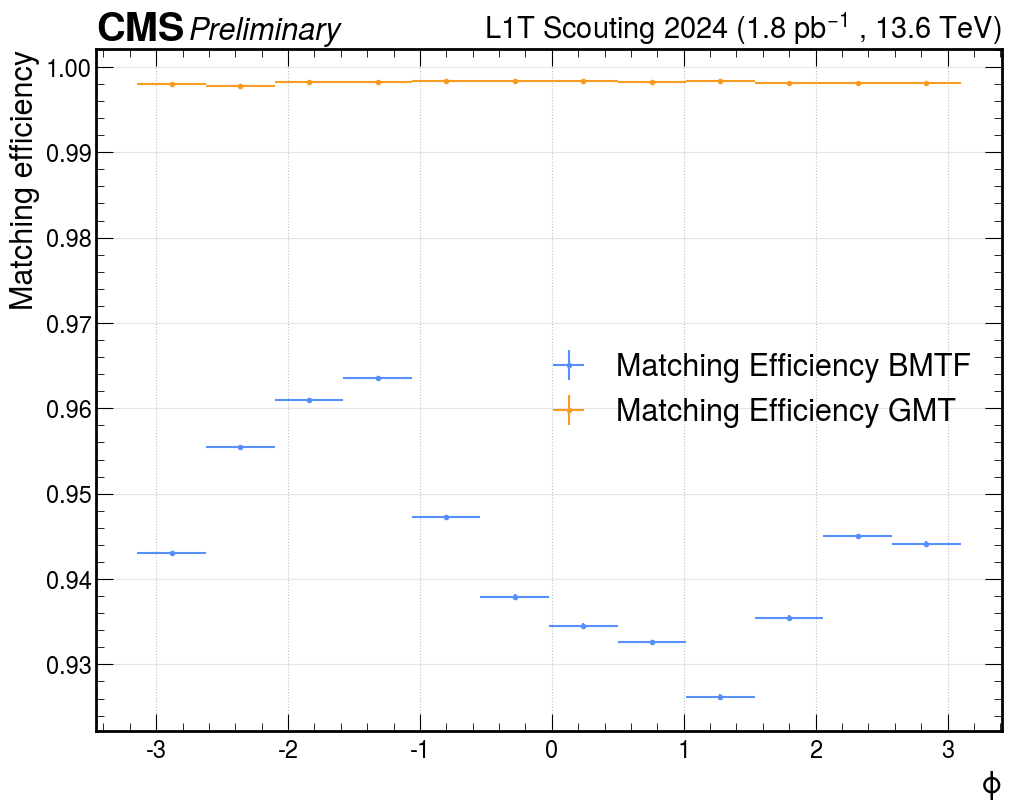

In [10]:
from hist import intervals
BMTFerror = hist.intervals.ratio_uncertainty(PhiBMTF_Hist.values(), AllPhiBMTF_Hist.values(), uncertainty_type = 'efficiency')
GMTerror = hist.intervals.ratio_uncertainty(PhiGMT_Hist.values(), AllPhiGMT_Hist.values(), uncertainty_type = 'efficiency')

centers = 0.5 * (binsPhi[1:] + binsPhi[:-1])
width = 0.5 * (binsPhi[1:] - binsPhi[:-1])

fig, ax = plt.subplots(figsize=FIGSIZE, constrained_layout=True)
set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE-2)
draw_grid(ax, axis="y")
draw_cms_label(ax, fontsize= FONTSIZE)

ax.errorbar(centers, BMTFMatchingEfficiencyPhi, xerr = width, yerr = BMTFerror, fmt = '.', label="Matching Efficiency BMTF")
ax.errorbar(centers, GMTMatchingEfficiencyPhi, xerr = width, yerr = GMTerror, fmt = '.', label="Matching Efficiency GMT")

#ax.set_ylim(0.888, 1.03)
#ax.set_xlim(-10, 310)


ax.set_xlabel(r'$\phi$')
ax.set_ylabel('Matching efficiency')
ax.grid(True)
ax.legend(fontsize = FONTSIZE)

ax.tick_params(axis='both', which='both', labelsize = FONTSIZE - 5)

plt.savefig("../Immagini/PhiMatchingEfficiency.pdf")


plt.show()

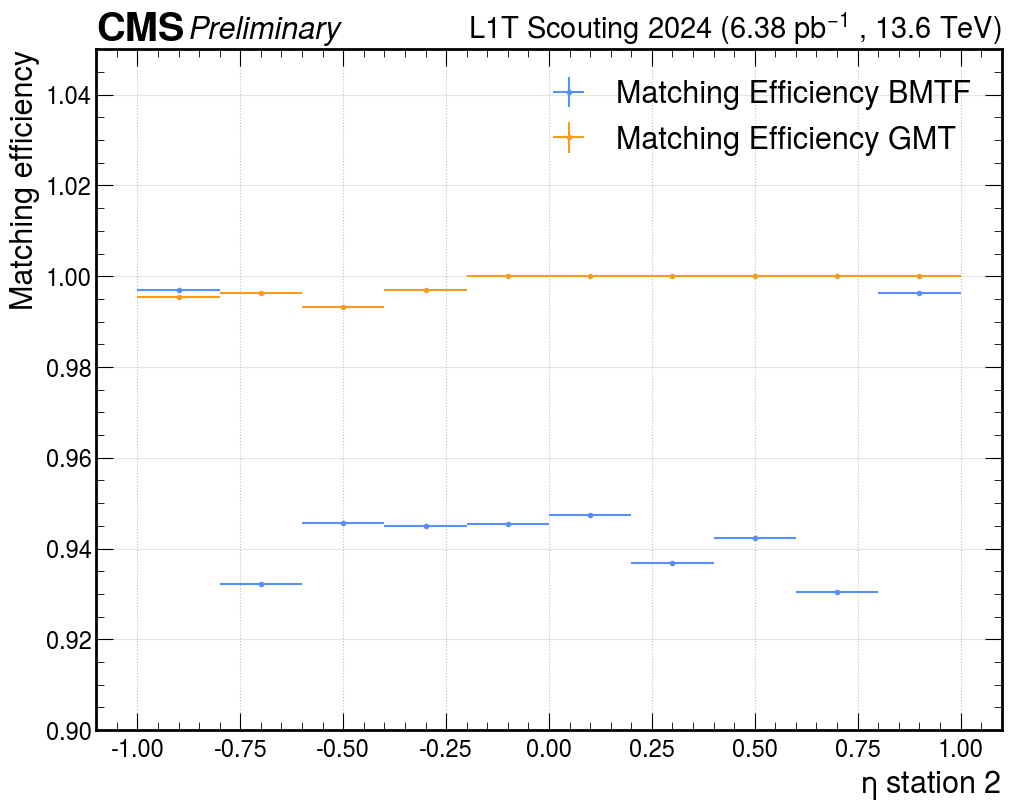

In [11]:
from hist import intervals
BMTFerror = hist.intervals.ratio_uncertainty(EtaBMTF_Hist.values(), AllEtaBMTF_Hist.values(), uncertainty_type = 'efficiency')
GMTerror = hist.intervals.ratio_uncertainty(EtaGMT_Hist.values(), AllEtaGMT_Hist.values(), uncertainty_type = 'efficiency')

centers = 0.5 * (binsEta[1:] + binsEta[:-1])
width = 0.5 * (binsEta[1:] - binsEta[:-1])

fig, ax = plt.subplots(figsize=FIGSIZE, constrained_layout=True)
set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE-2)
draw_grid(ax, axis="y")
MOREdraw_cms_label(ax, fontsize= FONTSIZE)

ax.errorbar(centers, BMTFMatchingEfficiencyEta, xerr = width, yerr = BMTFerror, fmt = '.', label="Matching Efficiency BMTF")
ax.errorbar(centers, GMTMatchingEfficiencyEta, xerr = width, yerr = GMTerror, fmt = '.', label="Matching Efficiency GMT")

ax.set_ylim(0.9, 1.05)
#ax.set_xlim(-10, 310)


ax.set_xlabel(r'$\eta$ station 2')
ax.set_ylabel('Matching efficiency')
ax.grid(True)
ax.legend(fontsize = FONTSIZE)

ax.tick_params(axis='both', which='both', labelsize = FONTSIZE - 5)

plt.savefig("../Immagini/EtaMatchingEfficiency.pdf")


plt.show()



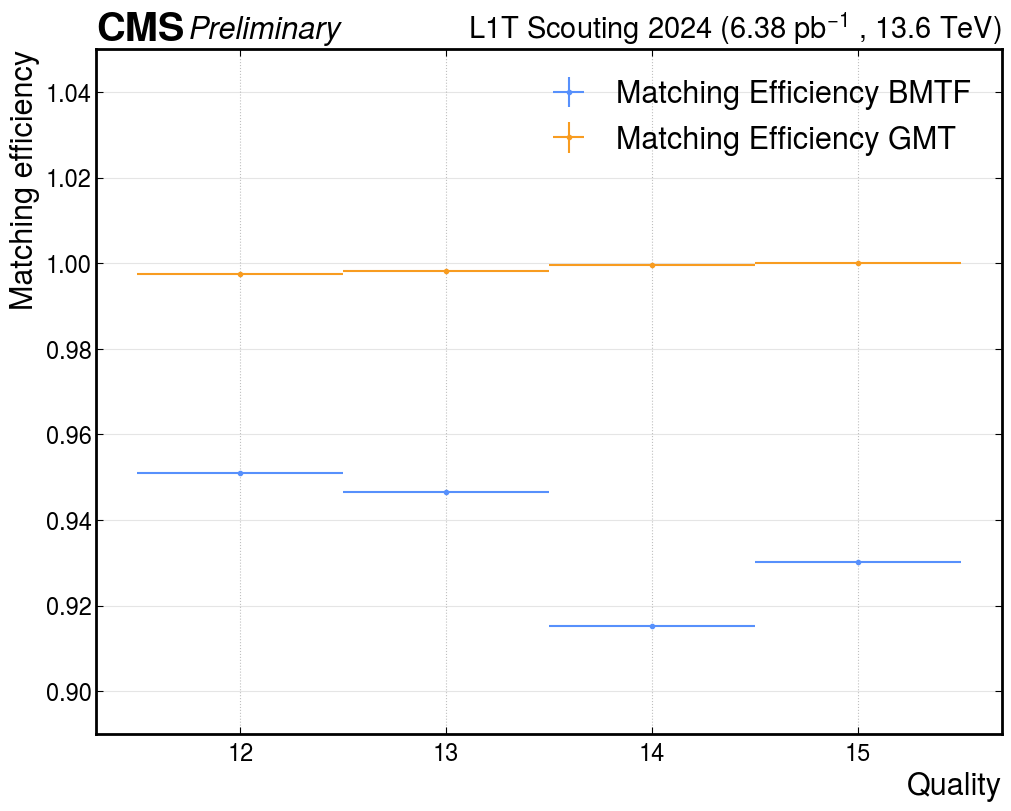

In [16]:
from hist import intervals
BMTFerror = hist.intervals.ratio_uncertainty(QualBMTF_Hist.values(), AllQualBMTF_Hist.values(), uncertainty_type = 'efficiency')
GMTerror = hist.intervals.ratio_uncertainty(QualGMT_Hist.values(), AllQualGMT_Hist.values(), uncertainty_type = 'efficiency')

centers = 0.5 * (binsQual[1:] + binsQual[:-1])
width = 0.5 * (binsQual[1:] - binsQual[:-1])

fig, ax = plt.subplots(figsize=FIGSIZE, constrained_layout=True)
set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE-2)
draw_grid(ax, axis="y")
MOREdraw_cms_label(ax, fontsize= FONTSIZE)

ax.errorbar(centers, BMTFMatchingEfficiencyQual, xerr = width, yerr = BMTFerror, fmt = '.', label="Matching Efficiency BMTF")
ax.errorbar(centers, GMTMatchingEfficiencyQual, xerr = width, yerr = GMTerror, fmt = '.', label="Matching Efficiency GMT")

ax.set_ylim(0.89, 1.05)
#ax.set_xlim(-10, 310)


ax.set_xlabel(r'Quality')
ax.set_ylabel('Matching efficiency')
ax.grid(True)
ax.legend(fontsize = FONTSIZE)

ax.tick_params(axis='both', which='both', labelsize = FONTSIZE - 5)

ax.tick_params(axis='both', which='minor', length=0, labelsize = FONTSIZE - 5)
ax.tick_params(axis='both', which='major', length=5, labelsize = FONTSIZE - 5)
ax.set_xticks(ticks=np.arange(12.5, 16.5), labels=np.arange(12, 16, 1))

plt.savefig("../Immagini/QualMatchingEfficiency.pdf")


plt.show()

# Grafici

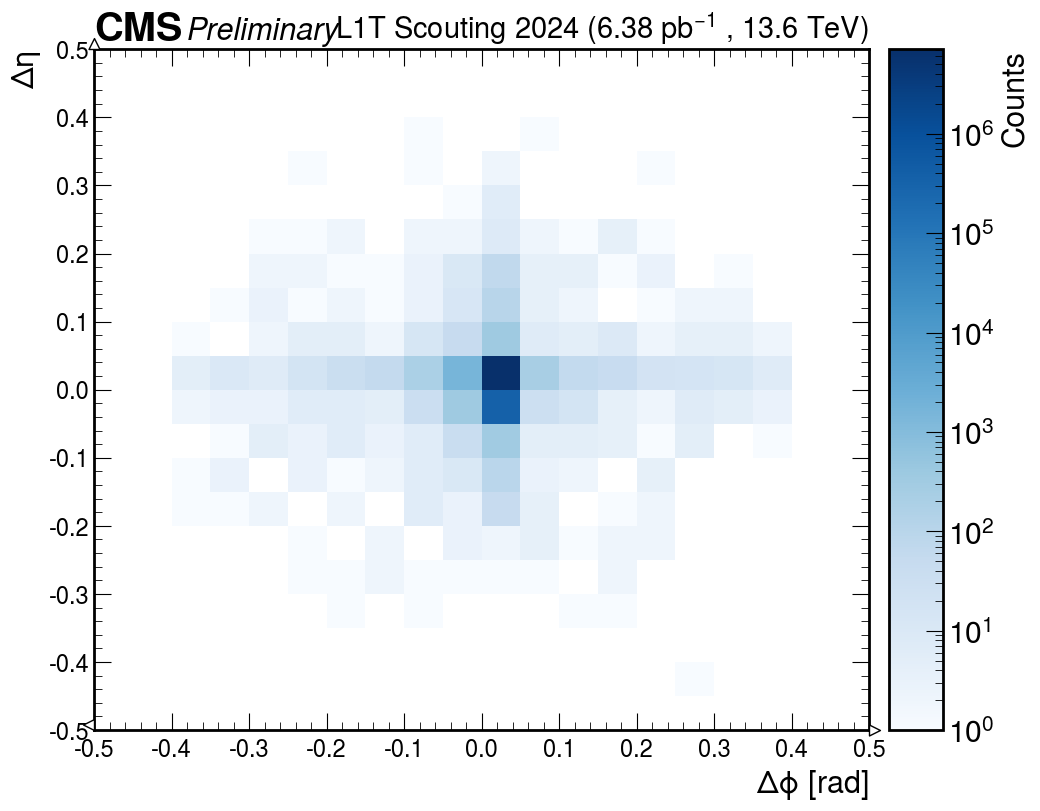

In [ ]:
DeltaPhi_GMT = MuonsPropertiesAll.DeltaPhiGMT
DeltaEta_GMT = MuonsPropertiesAll.DeltaEtaGMT

a = 0.5
DeltaPhiRange = np.arange(-a, a, 0.05)
DeltaEtaRange = np.arange(-a, a, 0.05)

hist2d = hist.Hist(
    hist.axis.Variable(DeltaPhiRange, name='Phi'),
    hist.axis.Variable(DeltaEtaRange, name='Eta')

)
hist2d.fill(Phi=ak.flatten(DeltaPhi_GMT), Eta=ak.flatten(DeltaEta_GMT))


fig, ax = plt.subplots(figsize=FIGSIZE, constrained_layout=True)
set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE-2)
draw_grid(ax, axis="y")
MOREdraw_cms_label(ax, fontsize= FONTSIZE)

hep.hist2dplot(hist2d, cbar=True, cmap='Blues', ax=ax,  norm = LogNorm())

cbar = ax.collections[0].colorbar
cbar.set_label('Counts', fontsize=FONTSIZE)

ax.set_xlabel(r'$\Delta \phi$ station 2 [rad]')
ax.set_ylabel(r'$\Delta \eta$ station 2')
ax.grid(False)
ax.set_xticks(np.arange(-0.5, 0.6, 0.1))
ax.set_yticks(np.arange(-0.5, 0.6, 0.1))

ax.tick_params(axis='both', which='both', labelsize = FONTSIZE - 5)


plt.savefig("../Immagini/DeltaR.pdf")

plt.show()

# Check Quality

In [18]:
BMTFQuality = bmtf_gmt.bmtfHwQual
QPtBMTF = MuonsPropertiesAll.PtBMTF
Unmatched_BMTF = MuonsPropertiesAll.unmatched_Bmtf_Events

LowPt = []
Pt = []
HighPt = []

for i in tqdm.tqdm(range(len(BMTFQuality))):
  if len(QPtBMTF[i]) != 0:
    for j in range(len(QPtBMTF[i])):
      if len(QPtBMTF[i]) > len(BMTFQuality[i]):
        continue
      elif QPtBMTF[i, j] < 10.5:
        LowPt.append(BMTFQuality[i, j])
        Pt.append(QPtBMTF[i, j])

      elif QPtBMTF[i, j] > 99.5:
        HighPt.append(BMTFQuality[i, j])
        #print(BMTFQuality[i, j], QPtBMTF[i, j]

AllPt = []

for i in tqdm.tqdm(range(len(BMTFQuality))):
  if len(QPtBMTF[i]) != 0:
    for j in range(len(QPtBMTF[i])):
      if len(QPtBMTF[i]) > len(BMTFQuality[i]):
        continue
      else:
        AllPt.append(BMTFQuality[i, j])

  1%|          | 241770/40525476 [00:15<44:13, 15180.54it/s]


KeyboardInterrupt: 

In [ ]:
# LowPt = ak.Array(LowPt)
# HighPt = ak.Array(HighPt)

# ak.to_parquet(LowPt, 'LowPt.parquet')
# ak.to_parquet(HighPt, 'HighPt.parquet')

# AllPt = ak.Array(AllPt)
# ak.to_parquet(AllPt, 'AllPt.parquet')

In [ ]:
binsQ = np.array([12, 13, 14, 15, 16])

LowPtQual_Hist = hist.Hist(hist.axis.Variable(binsQ, name="LowPtQual", ))
HighPtQual_Hist = hist.Hist(hist.axis.Variable(binsQ, name="HighPtQual",))
AllPtQual_Hist = hist.Hist(hist.axis.Variable(binsQ, name="AllPtQual",))

LowPtQual_Hist.fill(LowPtQual=LowPt)
HighPtQual_Hist.fill(HighPtQual=HighPt)
AllPtQual_Hist.fill(AllPtQual=AllPt)


LowPtRatio_Qual = LowPtQual_Hist.values() / ak.sum(LowPtQual_Hist.values())
HighPtRatio_Qual = HighPtQual_Hist.values() / ak.sum(HighPtQual_Hist.values())
AllPtRatio_Qual = AllPtQual_Hist.values() / ak.sum(AllPtQual_Hist.values())

QualRatioLow = LowPtRatio_Qual / AllPtRatio_Qual
QualRatioHigh = HighPtRatio_Qual / AllPtRatio_Qual
QualRatio = HighPtRatio_Qual / LowPtRatio_Qual


print("Low Pt ratio: ", LowPtRatio_Qual)
print("High Pt ratio:", HighPtRatio_Qual)
print("---------------------------------------------------------")
#print("Quality ratio Low/All: ", QualRatioLow)
#print("Quality ratio High/All: ", QualRatioHigh)
print("Quality ratio High/Low: ", QualRatio)

SigmaLow = np.sqrt((LowPtRatio_Qual * (1 - LowPtRatio_Qual) / ak.sum(LowPtQual_Hist.values())))
SigmaHigh = np.sqrt((HighPtRatio_Qual * (1 - HighPtRatio_Qual) / ak.sum(HighPtQual_Hist.values())))


Error = QualRatio*np.sqrt((SigmaLow/LowPtRatio_Qual)**2 + (SigmaHigh/HighPtRatio_Qual)**2)
print(Error)

In [ ]:
#High PT

from hist import intervals

fig, ax = plt.subplots(figsize=FIGSIZE, constrained_layout=True)
set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE-2)
draw_grid(ax, axis="y")
MOREdraw_cms_label(ax, fontsize= FONTSIZE)

hep.histplot(HighPtQual_Hist, label = r"BMTF muons quality in $p_T \in [100, 255]$ GeV/c", ax=ax, yerr = False, lw = 1.75, density=True)
hep.histplot(LowPtQual_Hist, label=r"BMTF muons quality in $p_T \in [0, 5.5]$ GeV/c", ax=ax, yerr = False, lw = 1.75, density = True)

ax.set_ylabel("Probability density", fontsize = FONTSIZE )
ax.legend(loc='upper right')

ax.set_yscale('log')
ax.set_ylim(0, 10)
ax.tick_params(axis='both', which='minor', length=0, labelsize = FONTSIZE - 5)
ax.tick_params(axis='both', which='major', length=5, labelsize = FONTSIZE - 5)

ax.set_xticks(ticks=np.arange(12.5, 16.5), labels=np.arange(12, 16, 1))


divider = make_axes_locatable(ax)
ax2 = divider.append_axes("bottom", 1.5, pad=0.1, sharex=ax)
ax2.tick_params(axis='x', which='minor', length=0, labelsize = FONTSIZE - 5)
ax2.tick_params(axis='x', which='major', length=5, labelsize = FONTSIZE - 5)

ax2.errorbar([12.5, 13.5, 14.5, 15.5], QualRatio, yerr = Error, fmt = 'o', c = 'black',)
ax2.hlines(1, 10.5, 18.5, color = 'gray', linestyle = 'dashed')

ax2.set_ylim(-2, 15)
ax2.set_xlim(11.4, 16.6)
ax2.set_ylabel("Ratio", fontsize = FONTSIZE - 4)
ax2.set_xlabel('Quality', fontsize = FONTSIZE )

#plt.savefig("../Immagini/QualLowHighPt.pdf", bbox_inches='tight')


# Controllo (SEMPRE BMTF) nelle regioni a basso e alto momento di PHI e ETA 

In [ ]:
BMTFEta = ak.concatenate([bmtf_awk_LS133.bmtfEta, bmtf_awk_LS263.bmtfEta, bmtf_awk_LS264.bmtfEta, bmtf_awk_LS306.bmtfEta])
BMTFPhi = ak.concatenate([bmtf_awk_LS133.bmtfPhi, bmtf_awk_LS263.bmtfPhi, bmtf_awk_LS264.bmtfPhi, bmtf_awk_LS306.bmtfPhi])
QPtBMTF = MuonsProperties.PtBMTF


LowPtEta, LowPtPhi = [], []

HighPtEta, HighPtPhi = [], []

for i in tqdm.tqdm(range(len(BMTFEta))):
  if len(QPtBMTF[i]) != 0:
    for j in range(len(QPtBMTF[i])):
      if len(QPtBMTF[i]) > len(BMTFEta[i]):
        continue
      elif QPtBMTF[i, j] < 5.5:
        LowPtEta.append(BMTFEta[i, j])
        LowPtPhi.append(BMTFPhi[i, j])

      elif QPtBMTF[i, j] > 99.5:
        HighPtEta.append(BMTFEta[i, j])
        HighPtPhi.append(BMTFPhi[i, j])

In [ ]:
#---------------------------------ETA--------------------------------------------------------
binsEta = np.arange(-1, 1.1, 0.2)

LowPtEta_Hist = hist.Hist(hist.axis.Variable(binsEta, name="LowPtEta", ))
HighPtEta_Hist = hist.Hist(hist.axis.Variable(binsEta, name="HighPtEta",))

LowPtEta_Hist.fill(LowPtEta=LowPtEta)
HighPtEta_Hist.fill(HighPtEta=HighPtEta)

LowPtRatio_Eta = LowPtEta_Hist.values() / ak.sum(LowPtEta_Hist.values())
HighPtRatio_Eta = HighPtEta_Hist.values() / ak.sum(HighPtEta_Hist.values())

EtaRatio = HighPtRatio_Eta / LowPtRatio_Eta

print("Eta ratio High/Low: ", EtaRatio)

SigmaLowEta = np.sqrt((LowPtRatio_Eta * (1 - LowPtRatio_Eta) / ak.sum(LowPtEta_Hist.values())))
SigmaHighEta = np.sqrt((HighPtRatio_Eta * (1 - HighPtRatio_Eta) / ak.sum(HighPtEta_Hist.values())))


ErrorEta = EtaRatio*np.sqrt((SigmaLowEta/LowPtRatio_Eta)**2 + (SigmaHighEta/HighPtRatio_Eta)**2)

#-----------------------------------PHI-----------------------------------------------------

binsPhi = np.array(np.arange(-np.pi, np.pi + 0.1, 0.52))

LowPtPhi_Hist = hist.Hist(hist.axis.Variable(binsPhi, name="LowPtPhi", ))
HighPtPhi_Hist = hist.Hist(hist.axis.Variable(binsPhi, name="HighPtPhi",))

LowPtPhi_Hist.fill(LowPtPhi=LowPtPhi)
HighPtPhi_Hist.fill(HighPtPhi=HighPtPhi)


LowPtRatio_Phi = LowPtPhi_Hist.values() / ak.sum(LowPtPhi_Hist.values())
HighPtRatio_Phi = HighPtPhi_Hist.values() / ak.sum(HighPtPhi_Hist.values())

PhiRatio = HighPtRatio_Phi / LowPtRatio_Phi

print("Phi ratio High/Low: ", PhiRatio)

SigmaLowPhi = np.sqrt((LowPtRatio_Phi * (1 - LowPtRatio_Phi) / ak.sum(LowPtPhi_Hist.values())))
SigmaHighPhi = np.sqrt((HighPtRatio_Phi * (1 - HighPtRatio_Phi) / ak.sum(HighPtPhi_Hist.values())))


ErrorPhi = PhiRatio*np.sqrt((SigmaLowPhi/LowPtRatio_Phi)**2 + (SigmaHighPhi/HighPtRatio_Phi)**2)
print("Error Phi: ", ErrorPhi)
print("Error Eta:", ErrorEta)

In [ ]:
fig, ax = plt.subplots(figsize=FIGSIZE, constrained_layout=True)
set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE-2)
draw_grid(ax, axis="y")
MOREdraw_cms_label(ax, fontsize= FONTSIZE)

hep.histplot(HighPtEta_Hist, label = r"BMTF muons $\eta$ in $p_T \in [100, 255]$ GeV/c", ax=ax, yerr = False, lw = 1.75, density=True)
hep.histplot(LowPtEta_Hist, label=r"BMTF muons $\eta$ in $p_T \in [0, 5.5]$ GeV/c", ax=ax, yerr = False, lw = 1.75, density = True)

ax.set_ylabel("Probability density", fontsize = FONTSIZE )
ax.legend(loc='upper right')

ax.set_yscale('log')
ax.set_ylim(0, 5)
ax.tick_params(axis='both', which='minor', length=0, labelsize = FONTSIZE - 5)
ax.tick_params(axis='both', which='major', length=5, labelsize = FONTSIZE - 5)

#ax.set_xticks(ticks=np.arange(12.5, 16.5), labels=np.arange(12, 16, 1))


divider = make_axes_locatable(ax)
ax2 = divider.append_axes("bottom", 1.5, pad=0.1, sharex=ax)
ax2.tick_params(axis='both', which='minor', length=0, labelsize = FONTSIZE - 5)
ax2.tick_params(axis='both', which='major', length=5, labelsize = FONTSIZE - 5)

binsEta = np.arange(-1, 0.9, 0.2)

ax2.errorbar(binsEta + (binsEta[1] - binsEta[0])/2, EtaRatio, yerr = ErrorEta, fmt = 'o', c = 'black',)
ax2.hlines(1, -2, 2, color = 'gray', linestyle = 'dashed')

ax2.set_ylim(0.35, 1.7)
ax2.set_xlim(-1.2, 1.2)
ax2.set_ylabel("Ratio", fontsize = FONTSIZE - 4)
ax2.set_xlabel(r'$\eta$', fontsize = FONTSIZE )

#plt.savefig("../Immagini/EtaLowHighPt.pdf", bbox_inches='tight')

# Controllo dei possibili duplicati 

In [ ]:
GmtEtaN = ak.flatten(GmtEta)

binsDup = np.array(np.arange(-1.2, 1.2, 0.1))

EtaDup_Hist = hist.Hist(hist.axis.Variable(binsDup, name="Eta", ))
AllEta_Hist = hist.Hist(hist.axis.Variable(binsDup, name="AllEta", ))

EtaDup_Hist.fill(Eta=EtaDup)
AllEta_Hist.fill(AllEta=GmtEtaN)

fig, ax = plt.subplots(figsize=FIGSIZE, constrained_layout=True)
set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE-2)
draw_grid(ax, axis="y")
MOREdraw_cms_label(ax, fontsize= FONTSIZE)


hep.histplot(EtaDup_Hist, label = r"GMT muons $\eta$ in $p_T \in [100, 255] GeV/c$", ax=ax, yerr = False, lw = 2, density = True)
hep.histplot(AllEta_Hist, label = r"GMT muons $\eta$ in $p_T \in [0, 255] GeV/c$", ax=ax, yerr = False, lw = 2, density = True)

ax.set_yscale('log')
ax.set_xlabel(r"$\eta$")
ax.set_ylabel("Probability density")
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(0.001, 20)

ax.legend(fontsize = FONTSIZE)

#plt.savefig("../Immagini/EtaHighPt.pdf")


In [ ]:
PtRange = np.arange(100, 265, 15)
EtaRange = np.arange(-1, 1.2, 0.2)

hist2d = hist.Hist(
    hist.axis.Variable(np.round(PtRange, 2), name='Pt', label='Pt number'),
    hist.axis.Variable(np.round(EtaRange, 2), name='Eta', label='Eta number'),
)

hist2d.fill(Pt=PtDup, Eta=EtaDup)

fig, ax = plt.subplots(figsize=FIGSIZE, constrained_layout=True)
set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE-2)
#draw_grid(ax, axis="y")
MOREdraw_cms_label(ax, fontsize= FONTSIZE)

from matplotlib.colors import LogNorm

hep.hist2dplot(hist2d, cbar=True, cmap='Blues', ax=ax, norm = LogNorm())
cbar = ax.collections[0].colorbar
cbar.set_label('Events', fontsize=FONTSIZE)

ax.set_xlabel("Vertex-constrained $p_T$")
ax.set_ylabel("$\eta$")

#plt.savefig("../Immagini/2DEtaHighPt.pdf")


In [ ]:
# gmtQuality = ak.concatenate([gmt_awk_LS133.gmtQual, gmt_awk_LS263.gmtQual, gmt_awk_LS264.gmtQual, gmt_awk_LS306.gmtQual])
# QPtGMT = MuonsProperties.PtGMT

# GMTLowPt = []
# Pt = []
# GMTHighPt = []

# for i in tqdm.tqdm(range(len(gmtQuality))):
#   if len(QPtGMT[i]) != 0:
#     for j in range(len(QPtGMT[i])):
#       if len(QPtGMT[i]) > len(gmtQuality[i]):
#         continue
#       elif QPtGMT[i, j] < 5.5:
#         GMTLowPt.append(gmtQuality[i, j])

#       elif QPtGMT[i, j] > 99.5:
#         GMTHighPt.append(gmtQuality[i, j])

In [ ]:
# GMTLowPt = ak.Array(GMTLowPt)
# GMTHighPt = ak.Array(GMTHighPt)

# ak.to_parquet(GMTLowPt, 'GMTLowPt.parquet')
# ak.to_parquet(GMTHighPt, 'GMTHighPt.parquet')

In [ ]:
binsQ = np.array([12, 13, 14, 15, 16])

LowPtQual_Hist = hist.Hist(hist.axis.Variable(binsQ, name="LowPtQual", ))
HighPtQual_Hist = hist.Hist(hist.axis.Variable(binsQ, name="HighPtQual",))

LowPtQual_Hist.fill(LowPtQual=GMTLowPt)
HighPtQual_Hist.fill(HighPtQual=GMTHighPt)


LowPtRatio_Qual = LowPtQual_Hist.values() / ak.sum(LowPtQual_Hist.values())
HighPtRatio_Qual = HighPtQual_Hist.values() / ak.sum(HighPtQual_Hist.values())


QualRatio = HighPtRatio_Qual / LowPtRatio_Qual



print("Quality ratio High/Low: ", QualRatio)

SigmaLow = np.sqrt((LowPtRatio_Qual * (1 - LowPtRatio_Qual) / ak.sum(LowPtQual_Hist.values())))
SigmaHigh = np.sqrt((HighPtRatio_Qual * (1 - HighPtRatio_Qual) / ak.sum(HighPtQual_Hist.values())))


Error = QualRatio*np.sqrt((SigmaLow/LowPtRatio_Qual)**2 + (SigmaHigh/HighPtRatio_Qual)**2)
print(Error)

In [ ]:
#High PT

from hist import intervals

fig, ax = plt.subplots(figsize=FIGSIZE, constrained_layout=True)
set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE-2)
draw_grid(ax, axis="y")
MOREdraw_cms_label(ax, fontsize= FONTSIZE)

hep.histplot(HighPtQual_Hist, label = r"GMT muons quality in $p_T \in [100, 255]$ GeV/c", ax=ax, yerr = False, lw = 1.75, density=True)
hep.histplot(LowPtQual_Hist, label=r"GMT muons quality in $p_T \in [0, 5.5]$ GeV/c", ax=ax, yerr = False, lw = 1.75, density = True)

ax.set_ylabel("Probability density", fontsize = FONTSIZE )
ax.legend(loc='upper right')

ax.set_yscale('log')
ax.set_ylim(0, 10)
ax.tick_params(axis='both', which='minor', length=0, labelsize = FONTSIZE - 5)
ax.tick_params(axis='both', which='major', length=5, labelsize = FONTSIZE - 5)

ax.set_xticks(ticks=np.arange(12.5, 16.5), labels=np.arange(12, 16, 1))


divider = make_axes_locatable(ax)
ax2 = divider.append_axes("bottom", 1.5, pad=0.1, sharex=ax)
ax2.tick_params(axis='both', which='minor', length=0, labelsize = FONTSIZE - 5)
ax2.tick_params(axis='both', which='major', length=5, labelsize = FONTSIZE - 5)

ax2.errorbar([12.5, 13.5, 14.5, 15.5], QualRatio, yerr = Error, fmt = 'o', c = 'black',)
ax2.hlines(1, 10.5, 18.5, color = 'gray', linestyle = 'dashed')

ax2.set_ylim(-5, 38)
ax2.set_xlim(11.4, 16.6)
ax2.set_ylabel("Ratio", fontsize = FONTSIZE - 4)
ax2.set_xlabel('Quality', fontsize = FONTSIZE )

#plt.savefig("../Immagini/GMTQualLowHighPt.pdf", bbox_inches='tight')
